<a href="https://colab.research.google.com/github/coll-j/B21-CAP0001/blob/ml/ML/Capstone_Binary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [ ]:
!pip install PySastrawi

     |████████████████████████████████| 215kB 6.8MB/s 


In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
import re
# import nltk
import matplotlib.pyplot as plt
import pickle
import string

from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.layers import *
from sklearn.model_selection import train_test_split
from gensim.models import FastText
from google.colab import drive
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [ ]:
nltk.download('punkt')

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


# Downloads

### Dataset

In [ ]:
!wget https://raw.githubusercontent.com/okkyibrohim/id-multi-label-hate-speech-and-abusive-language-detection/master/re_dataset.csv

--2021-05-30 05:04:58--  https://raw.githubusercontent.com/okkyibrohim/id-multi-label-hate-speech-and-abusive-language-detection/master/re_dataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1858473 (1.8M) [text/plain]
Saving to: ‘re_dataset.csv’

re_dataset.csv      100%[===================>]   1.77M  --.-KB/s    in 0.08s   

2021-05-30 05:04:58 (21.2 MB/s) - ‘re_dataset.csv’ saved [1858473/1858473]



### Kamus Alay

In [ ]:
!wget https://raw.githubusercontent.com/okkyibrohim/id-multi-label-hate-speech-and-abusive-language-detection/master/new_kamusalay.csv

--2021-05-30 05:05:01--  https://raw.githubusercontent.com/okkyibrohim/id-multi-label-hate-speech-and-abusive-language-detection/master/new_kamusalay.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 285941 (279K) [text/plain]
Saving to: ‘new_kamusalay.csv’

new_kamusalay.csv   100%[===================>] 279.24K  --.-KB/s    in 0.03s   

2021-05-30 05:05:02 (8.67 MB/s) - ‘new_kamusalay.csv’ saved [285941/285941]



# Read Data

In [ ]:
df = pd.read_csv('re_dataset.csv', encoding="ISO-8859-1")
df.head()

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,- disaat semua cowok berusaha melacak perhatia...,1,1,1,0,0,0,0,0,1,1,0,0
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,1,0,0,0,0,0,0,0,0,0,0
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0,0,0,0,0,0,0,0,0,0,0
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0,0,0,0,0,0,0,0,0,0,0
4,USER USER Kaum cebong kapir udah keliatan dong...,1,1,0,1,1,0,0,0,0,0,1,0


In [ ]:
df['Tweet'][5]

"USER Ya bani taplak dkk \\xf0\\x9f\\x98\\x84\\xf0\\x9f\\x98\\x84\\xf0\\x9f\\x98\\x84'"

In [ ]:
df['Tweet'][8]

'Nah admin belanja satu lagi port terbaik nak makan Ais Kepal Milo, Ais Kepal Horlicks atau Cendol Toping kaw kaw. ð??\xad; ; Doket mano tu ? Gerai Rojak Mertuaku - Taipan 2 (depan TWINS BABY &amp; ROMANTIKA / Bank Islam Senawang) ð???'

In [ ]:
len(df)

13169

# Pre-Processing

In [ ]:
kamus_alay = pd.read_csv('new_kamusalay.csv', encoding="ISO-8859-1", header=None)
kamus_alay.head()

,0,1
0,anakjakartaasikasik,anak jakarta asyik asyik
1,pakcikdahtua,pak cik sudah tua
2,pakcikmudalagi,pak cik muda lagi
3,t3tapjokowi,tetap jokowi
4,3x,tiga kali


In [ ]:
kamus_alay_dict = {}
for i, row in kamus_alay.iterrows():
  kamus_alay_dict[row[0]] = row[1]

kamus_alay_dict

{'anakjakartaasikasik': 'anak jakarta asyik asyik',
 'pakcikdahtua': 'pak cik sudah tua',
 'pakcikmudalagi': 'pak cik muda lagi',
 't3tapjokowi': 'tetap jokowi',
 '3x': 'tiga kali',
 'aamiin': 'amin',
 'aamiinn': 'amin',
 'aamin': 'amin',
 'aammiin': 'amin',
 'abis': 'habis',
 'abisin': 'habiskan',
 'acau': 'kacau',
 'achok': 'ahok',
 'ad': 'ada',
 'adek': 'adik',
 'adl': 'adalah',
 'adlah': 'adalah',
 'adlh': 'adalah',
 'ado': 'ada',
 'aduhh': 'aduh',
 'aer': 'air',
 'afdol': 'afdal',
 'agamaataualqur': 'agama alquran',
 'agm': 'agama',
 'agma': 'agama',
 'ahaha': 'haha',
 'ahahaha': 'haha',
 'ahehehehe': 'hehe',
 'ahir': 'akhir',
 'ahirnya': 'akhirnya',
 'ahk': 'ahok',
 'ahlamdulillah': 'alhamdulillah',
 'ahli2': 'para ahli',
 'ahlusunnah': 'ahlus sunah',
 'ahmaddani': 'ahmad dhani',
 'aho': 'ahok',
 'ahoax': 'ahok',
 'ahoaxx': 'ahok',
 'ahog': 'ahok',
 'ahokataudjarot': 'ahok djarot',
 'ahokbebanijokowi': 'ahok beban jokowi',
 'ahokbtp': 'ahok basuki tjahaja purnama',
 'ahokditolakw

## Cleaning text

In [ ]:
tweets = df['Tweet'].str.lower()
tweets

0        - disaat semua cowok berusaha melacak perhatia...
1        rt user: user siapa yang telat ngasih tau elu?...
2        41. kadang aku berfikir, kenapa aku tetap perc...
3        user user aku itu aku\n\nku tau matamu sipit t...
4        user user kaum cebong kapir udah keliatan dong...
                               ...                        
13164    user jangan asal ngomong ndasmu. congor lu yg ...
13165                         user kasur mana enak kunyuk'
13166    user hati hati bisu :( .g\n\nlagi bosan huft \...
13167    user user user user bom yang real mudah terdet...
13168    user mana situ ngasih(": itu cuma foto ya kuti...
Name: Tweet, Length: 13169, dtype: object

In [ ]:
tweets[0]

"- disaat semua cowok berusaha melacak perhatian gue. loe lantas remehkan perhatian yg gue kasih khusus ke elo. basic elo cowok bego ! ! !'"

In [ ]:
factory = StopWordRemoverFactory()
stopword = factory.create_stop_word_remover()

In [ ]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [ ]:
clean_tweets = tweets
query = r"http\S+| url" # hilangkan link
clean_tweets = list(map(lambda s: re.sub(query, ' ', s), clean_tweets))
query = r'\\t|\\n|\\u'
clean_tweets = list(map(lambda s: re.sub(query, ' ', s), clean_tweets))
query = r'user[:]? |\\[\\A-Za-z0-9]*|rt ' # Hilangkan 'USER', RT, dan encoding emoji ex: '\\xf0\\xxx\\xxx...'
clean_tweets = list(map(lambda s: re.sub(query, ' ', s), clean_tweets))
query = r'#[\w]*' # Hilangkan hashtags
clean_tweets = list(map(lambda s: re.sub(query, ' ', s), clean_tweets))
clean_tweets = list(map(lambda s: ' '.join([kamus_alay_dict.get(w, w) for w in s.split()]), clean_tweets)) # kamus alay
clean_tweets = list(map(lambda s: stemmer.stem(s), clean_tweets)) # stemming
# clean_tweets = list(map(lambda s: stopword.remove(s), clean_tweets)) # hilangkan stop words
query = r'\d+'
clean_tweets = list(map(lambda s: re.sub(query, ' ', s), clean_tweets)) # hilangkan angka
clean_tweets = list(map(lambda s: s.translate(str.maketrans(' ', ' ', string.punctuation)), clean_tweets)) # punctuation
query = r'(?:^| )\w(?:$| )'
clean_tweets = list(map(lambda s: re.sub(query, ' ', s), clean_tweets)) # hilangkan single letter
query = r" +"
clean_tweets = list(map(lambda s: re.sub(query, ' ', s.strip()), clean_tweets)) # hilangkan trailing spaces
clean_tweets

['di saat semua cowok usaha lacak perhati gue kamu lantas remeh perhati yang gue kasih khusus ke elo basic kamu cowok bego',
 'siapa yang telat beri tau elu edan sarap gue gaul dengan cigax jifla cal sama siapa itu licew juga',
 'kadang aku berfikir kenapa aku tetap percaya pada tuhan padahal aku selalu jatuh kali kadang aku rasa tuhan itu tinggal aku sendiri ketika orang tua rencana pisah ketika kakak lebih pilih jadi kristen ketika aku anak ter',
 'aku itu aku ku tau mata sipit tapi lihat dari mana itu aku',
 'kaum cebong kafir sudah lihat dongok dari awal tambah dungu lagi hahahah',
 'ya bani taplak dan kawan kawan',
 'deklarasi pilih kepala daerah aman dan anti hoaks warga dukuh sari jabon',
 'gue baru saja selesai rewatch aldnoah zero paling kampret memang endingnya karakter utama cowok kena friendzone bray xd',
 'nah admin belanja satu lagi po baik nak makan ais kepal milo ais kepal horlicks atau cendol toping kau kaw doket mana itu gerai rozak mertua taipan depan kembar baby amp

In [ ]:
del kamus_alay
del kamus_alay_dict

In [ ]:
kosong = []
for i in range(len(clean_tweets)):
  if len(clean_tweets[i]) <= 0:
    kosong.append(i)
    print('kosong di index: ', i)

kosong

kosong di index:  288
kosong di index:  2010
kosong di index:  5324
kosong di index:  6077
kosong di index:  6639
kosong di index:  7751


[288, 2010, 5324, 6077, 6639, 7751]

In [ ]:
kosong.sort()
kosong = kosong[::-1]
kosong

[7751, 6639, 6077, 5324, 2010, 288]

In [ ]:
for i in kosong:
  df = df.drop(i)
  del clean_tweets[i]

In [ ]:
y = df[df.columns[1]].to_numpy()
y

array([1, 0, 0, ..., 0, 0, 1])

In [ ]:
len(y), len(clean_tweets)

(13163, 13163)

## Tokenize
+ To sequence and padding

### Split first

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(clean_tweets, y, test_size=0.2, random_state=42)

len(X_train), len(y_train), len(X_test), len(y_test)

(10530, 10530, 2633, 2633)

In [ ]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(lower=True, oov_token=1)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_train

[[1428,
  107,
  611,
  7,
  9,
  650,
  363,
  1565,
  182,
  2,
  247,
  229,
  7,
  34,
  363,
  584,
  2530],
 [2,
  545,
  492,
  929,
  83,
  6481,
  1566,
  4,
  389,
  1650,
  91,
  545,
  688,
  722,
  279,
  13,
  585],
 [117, 31, 37, 76, 2302, 371, 112, 673, 44, 56, 1121],
 [138,
  264,
  6482,
  9,
  224,
  289,
  3749,
  2825,
  4,
  390,
  1178,
  499,
  173,
  6483,
  789,
  201,
  129,
  1567,
  98,
  5,
  6484,
  34,
  801,
  76,
  260,
  5,
  6485,
  5,
  45,
  379,
  98,
  238,
  789],
 [704, 17, 674, 187, 674, 275, 534],
 [30, 13, 113, 1429, 156, 55, 249, 120, 54, 166, 1179, 175],
 [45,
  552,
  1651,
  930,
  1178,
  5,
  1846,
  573,
  109,
  4641,
  376,
  266,
  377,
  5,
  4,
  469,
  3750,
  45,
  282,
  159,
  14,
  205,
  133,
  5,
  1178,
  449,
  83],
 [24, 6, 24, 371, 90, 163, 223, 37, 67, 20, 78, 6, 24],
 [38, 85, 69, 1652],
 [22,
  2,
  24,
  118,
  737,
  114,
  7,
  249,
  380,
  1032,
  45,
  1492,
  229,
  55,
  402,
  340,
  8,
  2,
  460,
  2121,


In [ ]:
X_test = tokenizer.texts_to_sequences(X_test)
X_test

[[594, 280, 188, 70],
 [79, 642],
 [995,
  127,
  130,
  9,
  19,
  209,
  33,
  197,
  165,
  394,
  289,
  319,
  5,
  3733,
  1,
  1,
  3747,
  165,
  7,
  33,
  390,
  81,
  40,
  1453,
  8,
  553,
  16,
  127,
  136,
  136,
  83],
 [184, 49, 1090, 367, 18, 10],
 [6,
  72,
  186,
  12,
  626,
  2014,
  1,
  6,
  4,
  8,
  5,
  251,
  9,
  1794,
  128,
  1989,
  146,
  246,
  626,
  1231,
  1,
  6,
  74,
  981,
  116,
  723,
  1953],
 [77, 351, 468, 884],
 [818, 18, 225, 1288, 92, 3321, 90, 398, 3456, 189, 978],
 [610, 513],
 [127,
  145,
  1160,
  127,
  145,
  158,
  304,
  498,
  132,
  21,
  1200,
  147,
  66,
  188,
  4,
  825,
  810,
  872,
  3,
  8,
  1304,
  872,
  3,
  899],
 [3073,
  268,
  23,
  444,
  16,
  2202,
  2961,
  3297,
  19,
  4,
  110,
  19,
  2,
  52,
  247,
  13,
  34,
  899,
  377,
  4,
  1352],
 [14, 90, 15, 223, 25, 79, 581, 223],
 [7514,
  1479,
  4,
  226,
  2491,
  26,
  116,
  321,
  146,
  26,
  16,
  1376,
  102,
  673,
  790,
  68,
  26,
  25,
  16

In [ ]:
with open('tokenizer_stem.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
max_len = max([len(seq) for seq in X_train])
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=max_len)
# X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=max_len, padding='post')

X_train # This will be the input

array([[   0,    0,    0, ...,  363,  584, 2530],
       [   0,    0,    0, ...,  279,   13,  585],
       [   0,    0,    0, ...,   44,   56, 1121],
       ...,
       [   0,    0,    0, ...,   64, 5346, 5347],
       [   0,    0,    0, ..., 1918,  474,   14],
       [   0,    0,    0, ...,   82,  221, 1459]], dtype=int32)

In [ ]:
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=max_len)
# X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=max_len, padding='post')

X_test # This will be the input

array([[    0,     0,     0, ...,   280,   188,    70],
       [    0,     0,     0, ...,     0,    79,   642],
       [    0,     0,     0, ...,   136,   136,    83],
       ...,
       [    0,     0,     0, ...,     4,   115,   755],
       [    0,     0,     0, ...,  8253,   513,   594],
       [    0,     0,     0, ...,    15, 13169,  2790]], dtype=int32)

### Ga Split First

In [ ]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(lower=True)
tokenizer.fit_on_texts(clean_tweets)
padded_sequence = tokenizer.texts_to_sequences(clean_tweets)
padded_sequence

[[160,
  66,
  480,
  276,
  3843,
  906,
  19,
  6,
  2217,
  2804,
  906,
  1,
  19,
  131,
  213,
  39,
  6,
  5623,
  6,
  480,
  312],
 [136,
  1,
  2089,
  1045,
  82,
  6,
  626,
  536,
  19,
  1972,
  17,
  7911,
  7912,
  5624,
  15,
  136,
  5,
  7913,
  24],
 [3844,
  761,
  26,
  1973,
  125,
  26,
  142,
  246,
  64,
  282,
  294,
  26,
  204,
  734,
  192,
  761,
  26,
  187,
  282,
  5,
  2380,
  26,
  172,
  417,
  9,
  7914,
  1267,
  1878,
  417,
  490,
  59,
  122,
  10,
  83,
  417,
  26,
  95,
  2090],
 [26, 5, 26, 82, 161, 206, 42, 72, 21, 81, 5, 26],
 [302, 57, 91, 13, 72, 181, 21, 457, 524, 181, 34, 118],
 [18, 228, 735, 3, 812, 812],
 [781, 113, 73, 56, 124, 331, 3, 139, 241, 218, 4518, 1879, 1336],
 [19,
  74,
  16,
  467,
  3392,
  7915,
  7916,
  5625,
  189,
  184,
  54,
  3393,
  1702,
  648,
  3845,
  305,
  7917,
  458,
  3846],
 [643,
  907,
  1046,
  88,
  34,
  7918,
  644,
  182,
  5626,
  4519,
  7919,
  5626,
  4519,
  7920,
  77,
  5627,
  7921,
 

In [ ]:
max_len = max([len(seq) for seq in padded_sequence])
padded_sequence = tf.keras.preprocessing.sequence.pad_sequences(padded_sequence, maxlen=max_len)
padded_sequence # This will be the input

array([[   0,    0,    0, ...,    6,  480,  312],
       [   0,    0,    0, ...,    5, 7913,   24],
       [   0,    0,    0, ...,   26,   95, 2090],
       ...,
       [   0,    0,    0, ...,    2, 1634, 2894],
       [   0,    0,    0, ...,  156, 1655,  899],
       [   0,    0,    0, ...,   18, 1916,  165]], dtype=int32)

#### Output

In [ ]:
y = df[df.columns[1]].to_numpy()
y

array([1, 0, 0, ..., 0, 0, 1])

In [ ]:
undersampler = RandomUnderSampler()
padded_sequence, y = undersampler.fit_resample(padded_sequence, y)
padded_sequence.shape, y.shape

NameError: ignored

#### Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(padded_sequence, y, test_size=0.02, stratify=y, random_state=42)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((10897, 58), (10897,), (223, 58), (223,))

(array([4448.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        4448.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

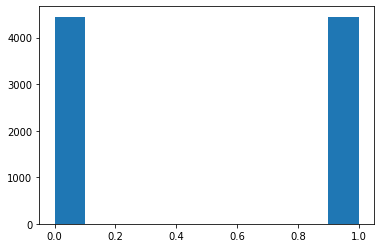

In [ ]:
plt.hist(y_train)

(array([1112.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1112.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

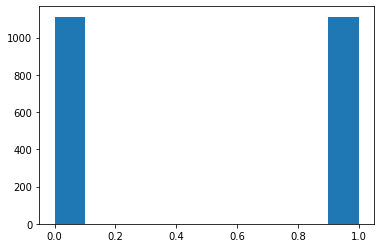

In [ ]:
plt.hist(y_test)

# Load FastText Word Embedding

In [ ]:
!tar -xvzf "drive/My Drive/Colab Notebooks/Capstone/id.tar.gz"

id.bin
id.vec


In [ ]:
!gzip -d "drive/My Drive/Colab Notebooks/Capstone/cc.id.300.bin.gz"

gzip: drive/My Drive/Colab Notebooks/Capstone/cc.id.300.bin.gz: No such file or directory


In [ ]:
embedding_path = 'id.bin' # repo
# embedding_path = 'drive/My Drive/Colab Notebooks/Capstone/cc.id.300.bin' # fast text
embedding_model = FastText.load_fasttext_format(embedding_path)

In [ ]:
embedding_size = embedding_model.vector_size
embedding_size

300

In [ ]:
embedding_model.most_similar('guru')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('pengajar', 0.6640160083770752),
 ('dosen', 0.6254853010177612),
 ('murid', 0.6231797337532043),
 ('guru-guru', 0.6127239465713501),
 ('mengajar', 0.5958520770072937),
 ('pendidik', 0.565003514289856),
 ('gurunya', 0.538303792476654),
 ('belajar', 0.5202033519744873),
 ('honorer', 0.5138474106788635),
 ('diajar', 0.5089484453201294)]

In [ ]:
embedding_model.most_similar('ahok')

[('tjahaja', 0.6268017292022705),
 ('jokowi', 0.6124308705329895),
 ('prabowo', 0.5613927245140076),
 ('bowo', 0.5557748675346375),
 ('basuki', 0.5413249731063843),
 ('subianto', 0.5392811298370361),
 ('dki', 0.5362879037857056),
 ('widodo', 0.5347503423690796),
 ('sby', 0.5129902362823486),
 ('joko', 0.5028191804885864)]

In [ ]:
embedding_model.most_similar('jokowi')

[('joko', 0.6402931809425354),
 ('sby', 0.6383484601974487),
 ('widodo', 0.6331063508987427),
 ('ahok', 0.6124308705329895),
 ('bowo', 0.6094229221343994),
 ('kalla', 0.5852698087692261),
 ('megawati', 0.5805439352989197),
 ('capres', 0.5768967270851135),
 ('prabowo', 0.5698248147964478),
 ('yudhoyono', 0.5645459890365601)]

## Generate embedding matrix

In [ ]:
embedding_matrix_ft = np.random.random((len(tokenizer.word_index) + 1, embedding_model.vector_size))

oov = 0
for word, i in tokenizer.word_index.items():
  try:
    embedding_matrix_ft[i] = embedding_model.wv[word]
  except:
    oov +=1

oov, embedding_matrix_ft

(7, array([[ 0.90866947,  0.2263665 ,  0.69264515, ...,  0.29731192,
          0.17408551,  0.50576573],
        [ 0.40865788,  0.4403512 ,  0.69558603, ...,  0.26366169,
          0.0497928 ,  0.68269114],
        [-0.07497611,  0.05221366,  0.09523099, ..., -0.00646898,
         -0.0818356 ,  0.00681653],
        ...,
        [-0.0874969 ,  0.0369548 , -0.1588686 , ...,  0.17675407,
         -0.37398615, -0.37959775],
        [-0.1980972 ,  0.14652643,  0.11782601, ..., -0.19258925,
          0.06163366, -0.31447965],
        [-0.27619657,  0.19139001,  0.00932065, ...,  0.2267704 ,
         -0.36651009, -0.3413032 ]]))

In [ ]:
del embedding_model

# Build Model

(array([7605.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        5560.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

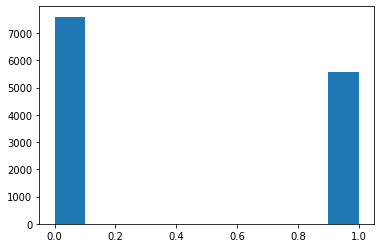

In [ ]:
plt.hist(y)

In [ ]:
len(tokenizer.word_index)

19540

In [ ]:
# LSTM Based
tf.keras.backend.clear_session()
model = tf.keras.Sequential()
model.add(InputLayer((max_len,)))
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, 
                    output_dim=embedding_size,
                    input_length=max_len,
                    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix_ft),
                    trainable=False
                    ))
# model.add(Bidirectional(LSTM(8, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
# model.add(Dropout(0.2))
# model.add(Bidirectional(LSTM(16, dropout=0.3, recurrent_dropout=0.3, recurrent_regularizer=tf.keras.regularizers.l2(0.001),  return_sequences=True)))
# model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(8, dropout=0.3, recurrent_dropout=0.3, recurrent_regularizer=tf.keras.regularizers.l2(0.001))))
# model.add(Bidirectional(LSTM(16, dropout=0.2, recurrent_dropout=0.2, recurrent_regularizer=tf.keras.regularizers.l2(0.001))))
# model.add(MaxPool1D())
# model.add(Dropout(0.5))
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
# CNN Based
tf.keras.backend.clear_session()
model = tf.keras.Sequential()
model.add(InputLayer((max_len,)))
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, 
                    output_dim=embedding_size,
                    input_length=max_len,
                    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix_ft),
                    trainable=False
                    ))
model.add(Conv1D(filters=16, kernel_size=3))
model.add(MaxPool1D(pool_size=3))
model.add(Dropout(0.5))
model.add(Conv1D(filters=8, kernel_size=3))
model.add(MaxPool1D(pool_size=3))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.summary()
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['acc'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 54, 300)           3960600   
_________________________________________________________________
bidirectional (Bidirectional (None, 16)                19776     
_________________________________________________________________
dense (Dense)                (None, 10)                170       
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 3,980,557
Trainable params: 19,957
Non-trainable params: 3,960,600
_________________________________________________________________


In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5)
lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(patience=3)
history = model.fit(X_train, y_train, 
          epochs=50, 
          batch_size=4,
          validation_data=(X_test, y_test),
          validation_batch_size=4,
          callbacks=[early_stopping, lr_reduce]
          ) # trial

Epoch 1/50
2633/2633 [==============================] - 198s 73ms/step - loss: 0.5865 - acc: 0.6886 - val_loss: 0.5259 - val_acc: 0.7345
Epoch 2/50
2633/2633 [==============================] - 193s 73ms/step - loss: 0.5019 - acc: 0.7642 - val_loss: 0.4801 - val_acc: 0.7660
Epoch 3/50
2633/2633 [==============================] - 194s 74ms/step - loss: 0.4619 - acc: 0.7906 - val_loss: 0.4893 - val_acc: 0.7687
Epoch 4/50
2633/2633 [==============================] - 192s 73ms/step - loss: 0.4314 - acc: 0.8088 - val_loss: 0.4613 - val_acc: 0.7847
Epoch 5/50
2633/2633 [==============================] - 193s 73ms/step - loss: 0.4127 - acc: 0.8168 - val_loss: 0.4672 - val_acc: 0.7774
Epoch 6/50
2633/2633 [==============================] - 192s 73ms/step - loss: 0.3880 - acc: 0.8323 - val_loss: 0.5205 - val_acc: 0.7717
Epoch 7/50
2633/2633 [==============================] - 193s 73ms/step - loss: 0.3811 - acc: 0.8349 - val_loss: 0.4938 - val_acc: 0.7778
Epoch 8/50
2633/2633 [===================

In [ ]:
from google.colab import files
files.download('binary_repo_83_41.h5') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
files.download('tokenizer_stem.pickle') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
pred = model.predict(np.expand_dims(padded_sequence[5, :], 0))

In [ ]:
pred, y[5]

(array([[0.12447414]], dtype=float32), 0)

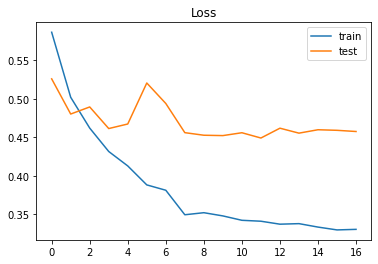

In [ ]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

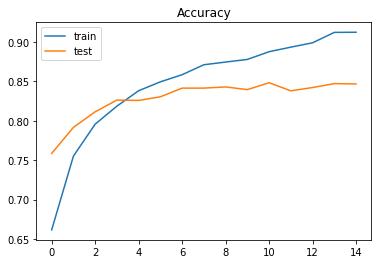

In [ ]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show()

In [ ]:
model.evaluate(X_test, y_test)

7/7 [==============================] - 0s 19ms/step - loss: 0.3820 - acc: 0.8341


[0.3819524347782135, 0.834080696105957]

In [ ]:
model.save('binary_repo_84_66.h5')

In [ ]:
sent = ['cina lu', 
        'keren anjing lu', 
        'anjing lu', 
        'gausah banyak bacot', 
        'hahahaha gila lu', 
        'Jadi cowo itu harus Gantle kalo ga Gantle itu namanya BANCI',
        'Islam Nusantara produk JIL, dipasarkan dg gencar oleh antek JIL. Sementara JIL anti Arab, tapi pro Aseng! Kata (alm) KH. Hasyim Muzadi']
seq = tokenizer.texts_to_sequences(sent)
seq

[[52, 428],
 [763, 148, 428],
 [148, 428],
 [1, 50, 305],
 [1393, 351, 428],
 [8, 2666, 6, 63, 6413, 1353, 991, 6413, 6, 1, 263],
 [28,
  168,
  680,
  1577,
  1,
  1,
  1767,
  105,
  130,
  1577,
  885,
  1577,
  139,
  407,
  36,
  536,
  495,
  64,
  5476,
  1396,
  4314,
  5477]]

In [ ]:
seq = tf.keras.preprocessing.sequence.pad_sequences(seq, maxlen=max_len)
seq

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,   52,  428],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,  763,  148,  428],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0

In [ ]:
pred = model.predict(seq)
np.round(pred, 0)

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]], dtype=float32)